# Stock Prices Paths Simulation

In [40]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
from yahoo_fin import options
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import sys
plt.style.use('default')
pio.templates.default = "seaborn"

sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(27)

### Get Option Data

In [41]:
symbol = 'AAPL'  # AAPL, TSLA, MSFT, META, CAT, STM, GOOG, NFLX, AMZN
dates = options.get_expiration_dates(symbol)
# print(dates)

T_str = 'June 21, 2024'  # This is the first "greater than a year" expiry date
calls = options.get_calls(symbol, T_str)
puts = options.get_puts(symbol, T_str)

T_datetime = datetime.strptime(T_str, '%B %d, %Y')
ttm = (T_datetime - datetime.now()).days / 365.0  # to use the time to maturity in float mode

calls['Time-to-maturity'] = ttm
puts['Time-to-maturity'] = ttm
# display(calls.columns)
print(calls.head())

         Contract Name         Last Trade Date  Strike  Last Price  Bid  Ask   
0  AAPL240621C00050000  2023-08-21 11:25AM EDT    50.0      125.97  0.0  0.0  \
1  AAPL240621C00055000  2023-08-21 11:26AM EDT    55.0      121.16  0.0  0.0   
2  AAPL240621C00060000   2023-08-21 2:53PM EDT    60.0      118.35  0.0  0.0   
3  AAPL240621C00065000   2023-08-11 3:36PM EDT    65.0      115.80  0.0  0.0   
4  AAPL240621C00070000   2023-08-11 3:06PM EDT    70.0      111.15  0.0  0.0   

   Change % Change  Volume  Open Interest Implied Volatility  Time-to-maturity  
0     0.0        -      46           1505              0.00%          0.827397  
1     0.0        -      47           1031              0.00%          0.827397  
2     0.0        -       5           1173              0.00%          0.827397  
3     0.0        -       7           1769              0.00%          0.827397  
4     0.0        -       2            793              0.00%          0.827397  


#### Find historical volatility

In [42]:
# historic volatility
stock_data = si.get_data(symbol, start_date='31/05/2021', end_date='31/05/2023')
# print(stock_data.head())
stock_data['Returns'] = stock_data['close'] / stock_data['close'].shift()
stock_data['Log Returns'] = np.log(stock_data['Returns'])
print(stock_data.head())
volatility = stock_data['Log Returns'].std() * np.sqrt(252)
print(f'\n{symbol} historical volatility: {round(volatility, 3)}')

                  open        high         low       close    adjclose   
2021-06-01  125.080002  125.349998  123.940002  124.279999  122.674835  \
2021-06-02  124.279999  125.239998  124.050003  125.059998  123.444763   
2021-06-03  124.680000  124.849998  123.129997  123.540001  121.944389   
2021-06-04  124.070000  126.160004  123.849998  125.889999  124.264038   
2021-06-07  126.169998  126.320000  124.830002  125.900002  124.273903   

              volume ticker   Returns  Log Returns  
2021-06-01  67637100   AAPL       NaN          NaN  
2021-06-02  59278900   AAPL  1.006276     0.006257  
2021-06-03  76229200   AAPL  0.987846    -0.012229  
2021-06-04  75169300   AAPL  1.019022     0.018844  
2021-06-07  71057600   AAPL  1.000079     0.000079  

AAPL historical volatility: 0.297


### Data preparation

In [43]:
# convert the 'Implied Volatility' column to a numeric type
calls['Implied Volatility'] = pd.to_numeric(calls['Implied Volatility'].str.strip('%')) / 100
puts['Implied Volatility'] = pd.to_numeric(puts['Implied Volatility'].str.strip('%')) / 100
# choose one option as starting point
option = calls.iloc[np.random.randint(len(calls))]
print(option)

Contract Name            AAPL240621C00145000
Last Trade Date       2023-08-22 12:33PM EDT
Strike                                 145.0
Last Price                             42.48
Bid                                      0.0
Ask                                      0.0
Change                                   0.0
% Change                                   -
Volume                                     1
Open Interest                           3332
Implied Volatility                       0.0
Time-to-maturity                    0.827397
Name: 19, dtype: object


#### Fix simulation parameters

In [44]:
# FIXED PARAMETERS (used for all models)
#S0 = si.get_live_price(symbol)  # get live price of stock
S0 = 100.0
print(f'{symbol} Current stock price: {round(S0, 2)}')
T = ttm  # Expiry Date in years
days = 252
paths = 1000
K = option[2]  # Strike price
sigma = 0.153
r = 0.03  # risk.free interest rate
q = 0
size = (days, paths)
exercise = 'european'

AAPL Current stock price: 100.0


### Black and Scholes model

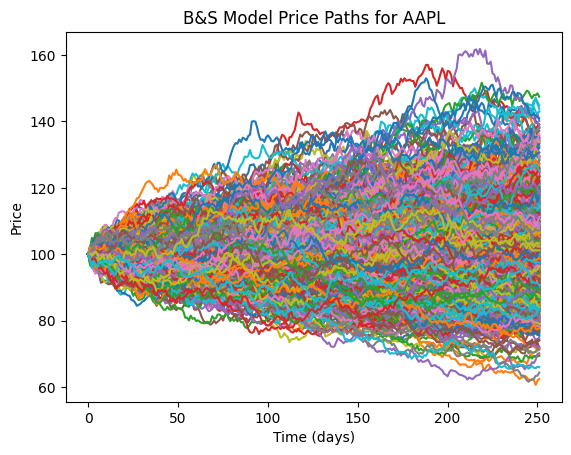

<Figure size 1000x600 with 0 Axes>

In [45]:
BS = BS_Pricer(S0, r, q, sigma, T, exercise, K)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)  # Plot all paths

#### Plot a subset of paths

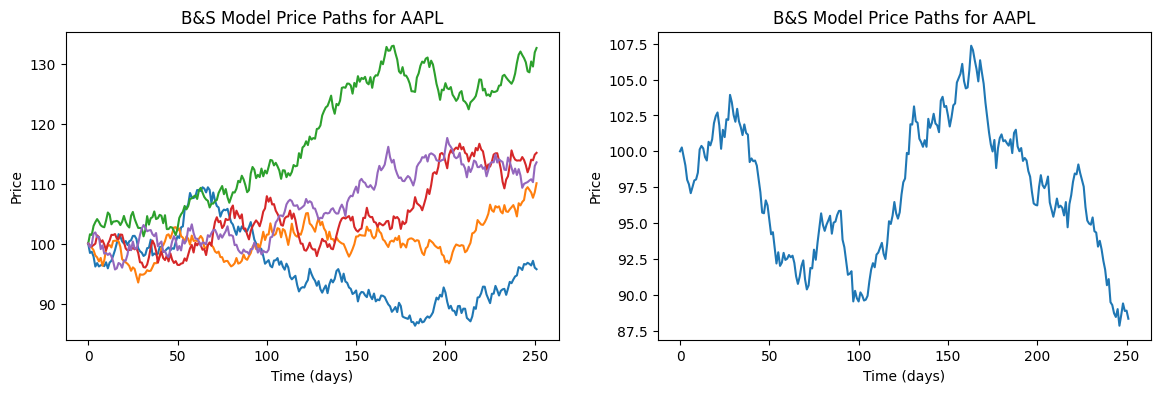

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [46]:
# Plot a subset of 5
subset = 5
SBS_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SBS_subset[path] = SBlackScholes[:, random_indices[path]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
BS.plotBSPath(SBS_subset.T, symbol, ax =axes[0] )
BS.plotBSPath(SBlackScholes[:, np.random.choice(paths)], symbol, ax=axes[1])  # Plot only one
plt.show()

### Merton Jump Diffusion model

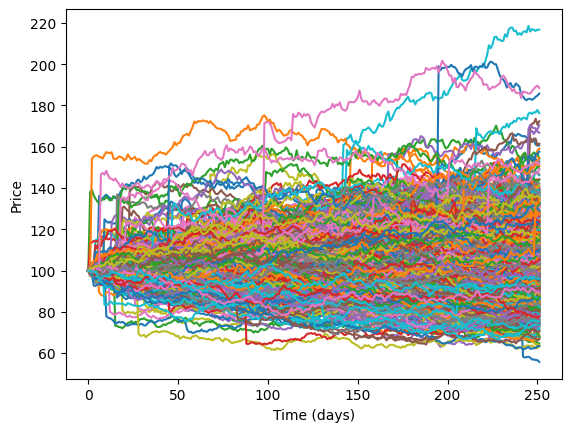

<Figure size 1000x600 with 0 Axes>

In [47]:
lamda = 0.5
jump_mean = 0.05
jump_std = 0.15
Merton = Merton_pricer(S0, K, T, r, q, sigma, lamda, jump_mean, jump_std, exercise)
SMerton = Merton.MertonPath(days, paths)
Merton.plotMertonPath(SMerton, symbol)  # Plot all paths

#### Plot subsets of paths

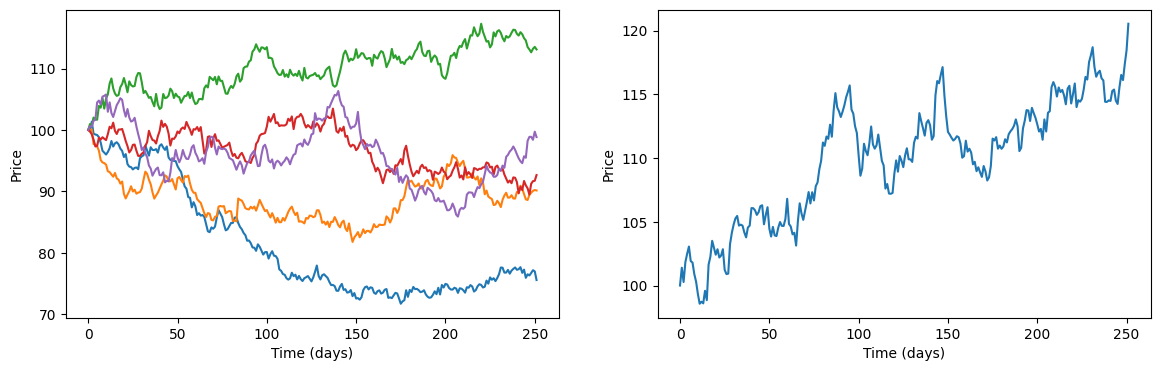

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [48]:
subset = 5  # Plot a subset of 5
SM_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SM_subset[path] = SMerton[:, random_indices[path]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
Merton.plotMertonPath(SM_subset.T, symbol, ax=axes[0])
Merton.plotMertonPath(SMerton[:, np.random.choice(paths)], symbol, ax=axes[1])  # Plot only one
plt.show()

### Kou Jump Diffusion Model

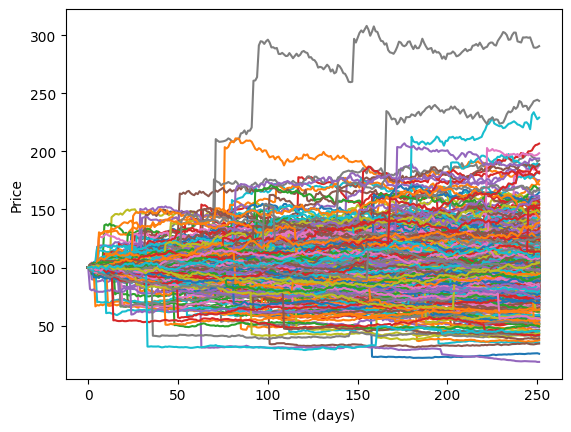

<Figure size 1000x600 with 0 Axes>

In [49]:
lamda = 1
eta1 = 8  # upward jump magnitude
eta2 = 5  # downward jump
p = 0.6  # q = 0.6
KOU = Kou_pricer(S0, K, T, r, sigma, lamda, p, eta1, eta2, exercise)
SKou = KOU.KouPath(days, paths)

# Plot all paths
KOU.plotKouPath(SKou, symbol)

#### Plot subsets of paths

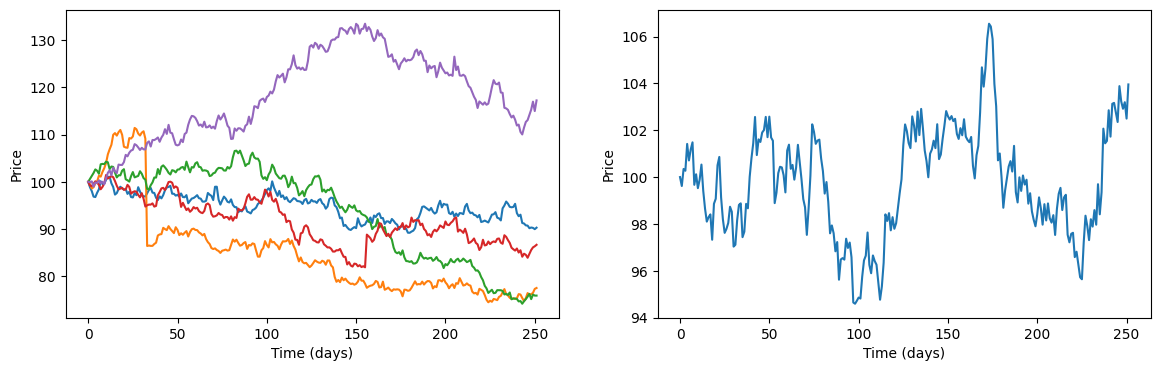

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [50]:
# Plot a subset of 5
subset = 5
SK_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SK_subset[path] = SKou[:, random_indices[path]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
KOU.plotKouPath(SK_subset.T, symbol, ax=axes[0])
KOU.plotKouPath(SKou[:, np.random.choice(paths)], symbol, ax=axes[1])
plt.show()

### Variance Gamma Model

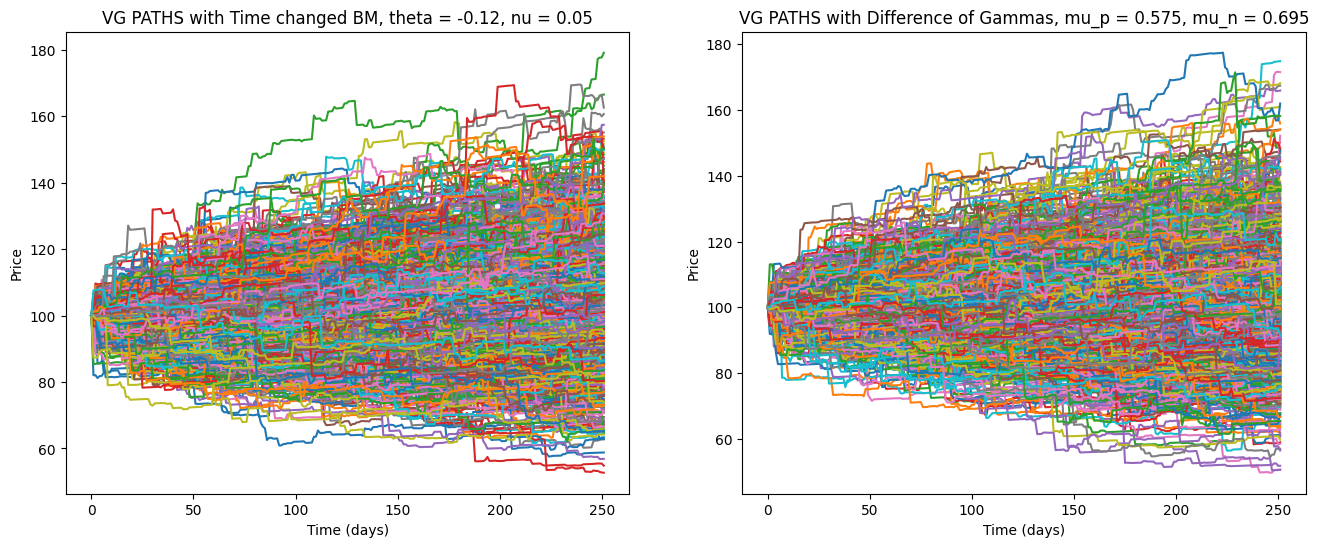

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [51]:
sigma = 0.2
theta = -0.12
nu = 0.05
VG = VG_pricer(S0, K, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()



#### Plot a subset of 5 paths

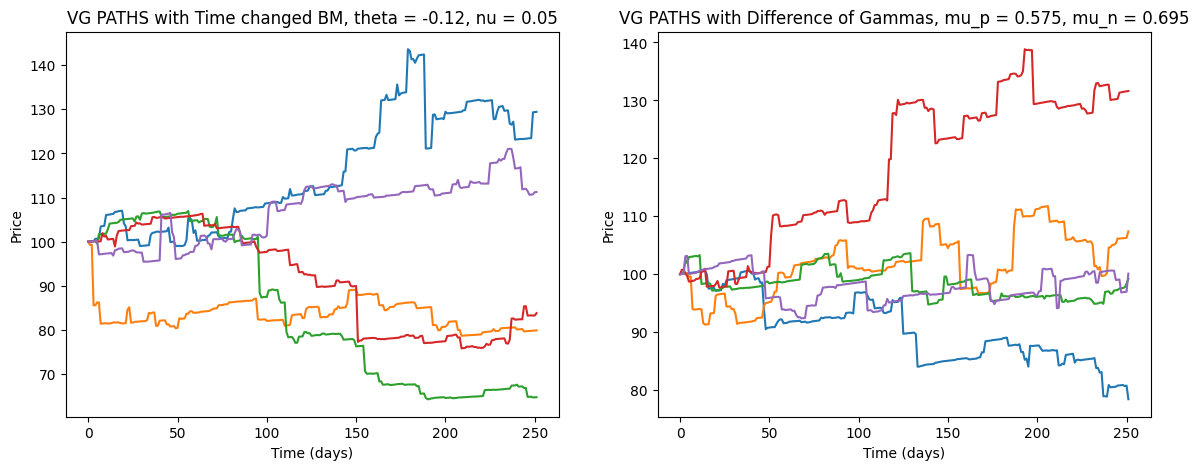

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [52]:
fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

subset = 5  # Plot a subset of 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma[:, random_indices[path]]
VG.plotVGPath(SVG_subset.T, symbol, method[0], ax=axes[0])

subset = 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma2[:, random_indices[path]]
VG.plotVGPath(SVG_subset.T, symbol, method[1], ax=axes[1])

In [53]:
print(VG.get_mu_p)
print(VG.get_mu_n)
print(VG.get_nu_p)
print(VG.get_nu_n)

0.5752952069707438
0.6952952069707437
0.016548228758175545
0.024171771241824465


#### Plot only one random path

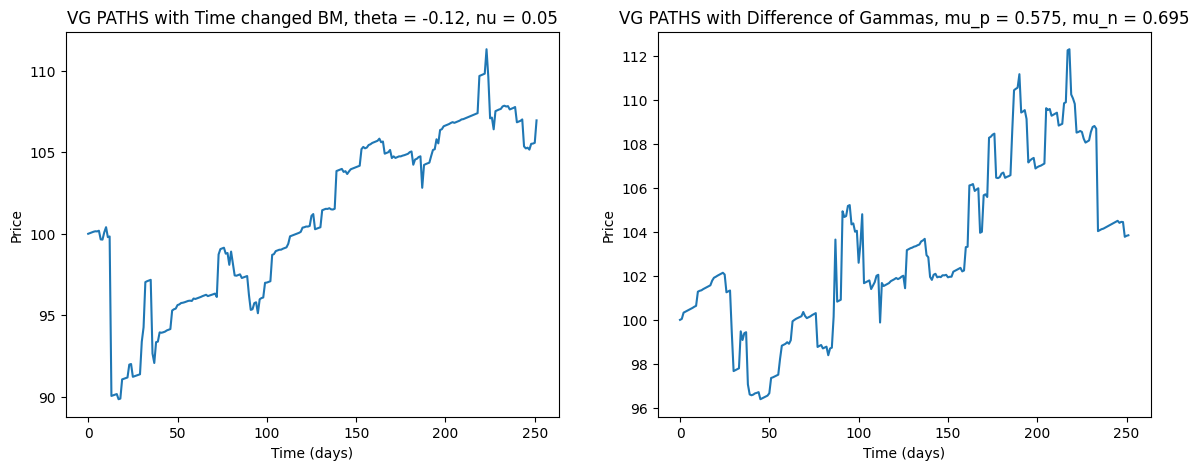

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [54]:
# Plot only one
fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
VG.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[1], ax=axes[1])
plt.tight_layout()

#### From Seneta 2004, moments method

In [55]:
# Estimate params of VG (ref. Seneta 2004)
sigma_est = np.sqrt(VG.find_moment(2))
theta_est = sigma*(VG.find_moment(3))/(3*nu)
nu_est = (VG.find_moment(4)/3) - 1

print(f'Variance Gamma Estimated Params\n\t\tSTART\tEXT')
print(f'Sigma:  {round(sigma,2)} -> {round(sigma_est,4)}')
print(f'Theta: {theta} -> {round(theta_est,4)}')
print(f'Nu:     {nu} -> {round(nu_est,4)}')

Variance Gamma Estimated Params
		START	EXT
Sigma:  0.2 -> 0.1198
Theta: -0.12 -> -0.0003
Nu:     0.05 -> -0.9998


### Visualize distributions
#### Distribution of prices

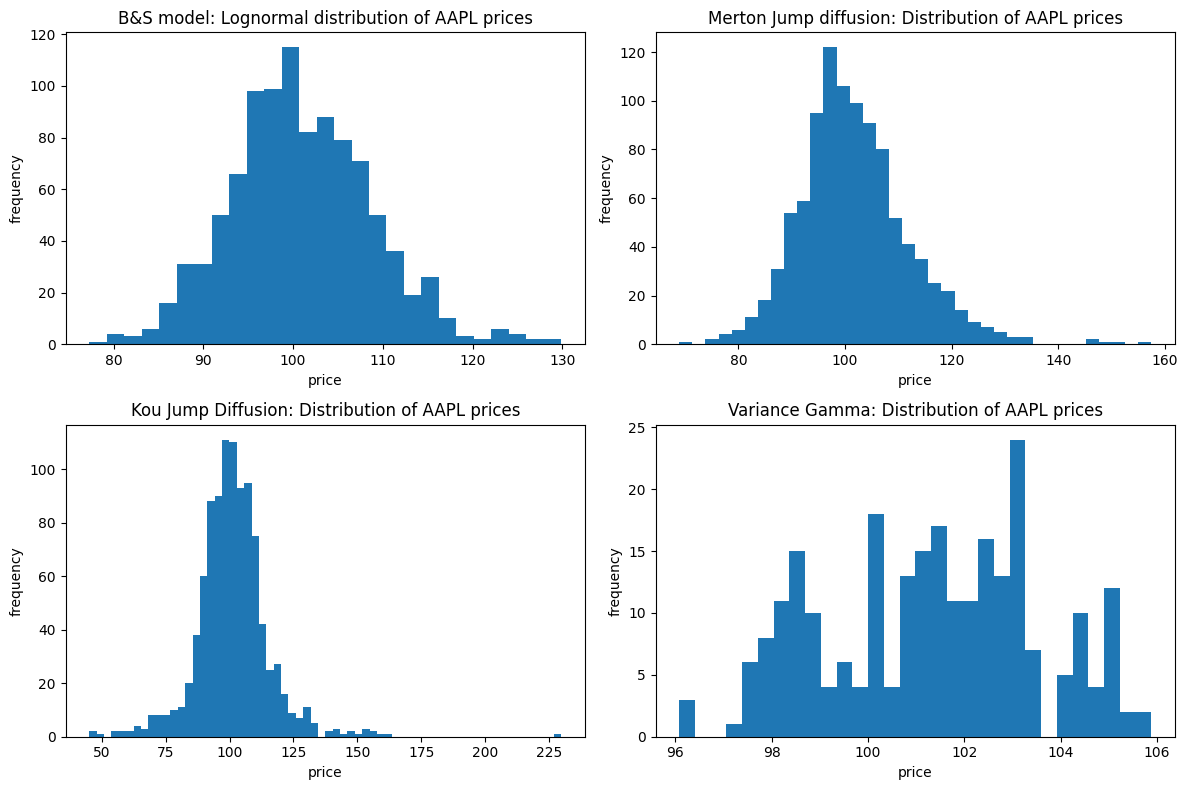

In [56]:
# %%%%%%%%%%%%%%%%%%%%%%%%    Visualize distributions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Average prices
fig4, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
BS.plotBSDist(SBlackScholes, symbol, ax = axes[0,0])
Merton.plotMertonDist(SMerton, symbol, ax = axes[0,1])
KOU.plotKouDist(SKou, symbol, ax = axes[1,0])
VG.plotVGDist(SVG_subset, symbol, ax = axes[1,1])
plt.tight_layout()
plt.show()

#### Cumulative distribution of Log returns

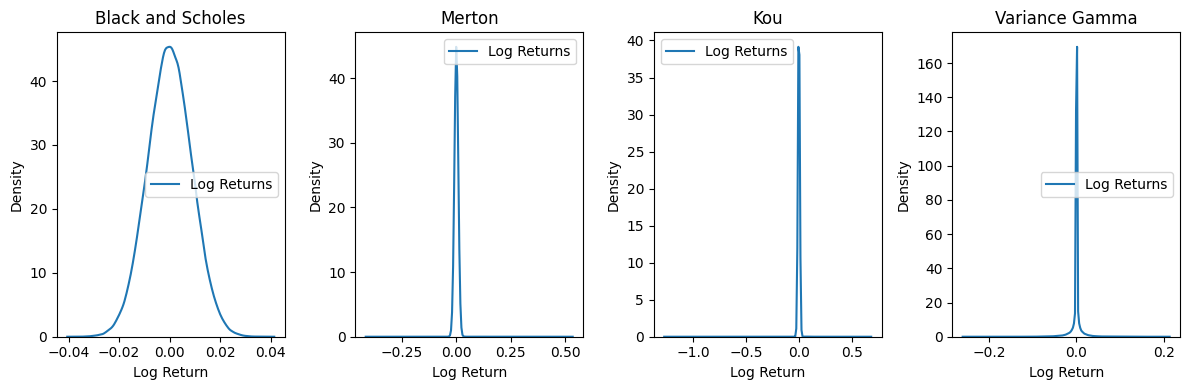

In [57]:
# Log returns ALL PATHS
fig5, axes5 = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
BS.plotBSLogReturns(SBlackScholes, symbol, ax=axes5[0])
Merton.plotMertonLogReturns(SMerton, symbol, ax=axes5[1])
KOU.plotKouLogReturns(SKou, symbol, ax=axes5[2])
VG.plotVGLogReturns(SVarGamma2, symbol, ax=axes5[3])
plt.tight_layout()

#### Distribution of Log Returns of a Sampled Path

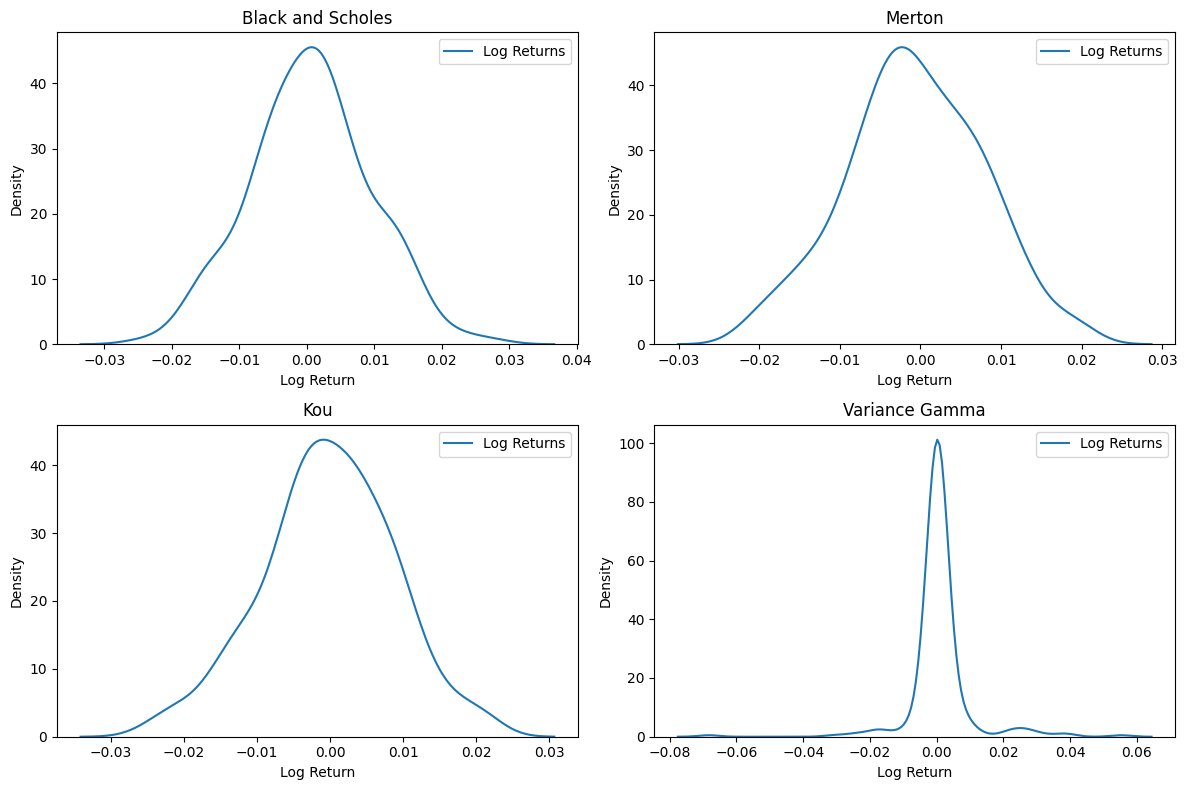

In [58]:
# Log returns ONE RANDOM
fig6, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
BS.plotBSLogReturns(SBlackScholes[:, np.random.choice(paths)], symbol, axes6[0,0])
Merton.plotMertonLogReturns(SMerton[:, np.random.choice(paths)], symbol, axes6[0,1])
KOU.plotKouLogReturns(SKou[:, np.random.choice(paths)], symbol, axes6[1,0])
VG.plotVGLogReturns(SVarGamma2[:, np.random.choice(paths)], symbol, axes6[1,1])
plt.tight_layout()


## Calibrated parameters
Before simulating paths with the calibrated parameters, let's retrieve the SP500 real data from Jan 2016 to Jan 2018. These data have been collected from [yahoo-finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC) and preprocessed in `StockAnalysis.ipynb`.

In [82]:
# SP500 real data
spx_data = pd.read_csv('data/SPX/SPX_data.csv')

spx_data['Returns'] = spx_data['Close'] / spx_data['Close'].shift()
spx_data['Log Returns'] = np.log(spx_data['Returns'])
print(spx_data.head())

         Date         Open         High          Low        Close      Volume   
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000  \
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000   
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000   
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000   
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000   

    Returns  Log Returns  
0       NaN          NaN  
1  1.005195     0.005182  
2  1.020284     0.020081  
3  0.984362    -0.015762  
4  1.014144     0.014045  


The model parameters have been calibrated on the SPX index on options starting on January 16, 2016. Now we can simulate paths using the just calibrated parameters for each model.

In [83]:
bs_sigma = 0.1491                                  # [σ]

#mert_params = [0.1141, 0.42, -0.22, 0.3394]
# mert_params = [ 0.11156,  0.9275, -0.0795,  0.0848 ]
mert_params = [0.0878, 0.9085, -0.118, 0.0963]           # [σ, λ, m, v]
mert_params2 = [0.0713, 0.7368, -0.1748, 0.0]


#kou_params = [0.21022, 0.04, 0.4, 0.0, 15.0]        # [σ, λ, p, η_1, η_2]
# kou_params = [0.0863, 2.2065, 0.0, 9.8519, 15.0]
#kou_params = [0.07, 0.9296, 0.2498, 13.0534, 6.5574]
kou_params = [0.0932, 0.361, 0.2877, 12.5685, 3.2118]

# vg_params= [0.14575, 0.11985, 0.41850]
# vg_params = [0.2633, -0.1039, 0.0138]                   # [σ, θ, v]
vg_params = [0.151, 0.0107, 0.0909]                 #### LAST CALIBRATION; GOOD
#vg_params = [0.1259, 0.1921, 0.3751]

S0 = spx_data.loc[0, 'Close']
r = 0.05
T = 1
symbol = 'SPX'

#### Historical data from SPX Time Series (2016-2018)

In [84]:
# SPX value at 20/01/2016
SPX_S0 = spx_data.loc[spx_data['Date'] == '2016-01-20', 'Close'].values[0]

# SPX value after 252 days
SPX_St = spx_data.loc[spx_data['Date'] == '2017-01-18', 'Close'].values[0]

print(f'\nSPX value on the 20th Jan, 2016: {SPX_S0}')
print(f'SPX value after 252 days (on Jan 18, 2017): {SPX_St}')


SPX value on the 20th Jan, 2016: 1859.3299560546875
SPX value after 252 days (on Jan 18, 2017): 2271.889892578125


In [85]:
spx_data['Date'] = pd.to_datetime(spx_data['Date'])

# Historic volatility 1 year
start_date = pd.to_datetime('2016-01-20')
end_date_1y = pd.to_datetime('2017-01-20')

selected_data_1y = spx_data.loc[(spx_data['Date'] >= start_date) & (spx_data['Date'] <= end_date_1y), 'Close']
sp_vola_1y = selected_data_1y.pct_change().std() * np.sqrt(days)
print(f'Historical volatility (1 year): {round(sp_vola_1y, 4)}, {round(sp_vola_1y*100,3)}%')

# Historic volatility 2 years
end_date_2y = pd.to_datetime('2018-01-20')

selected_data_2y = spx_data.loc[(spx_data['Date'] >= start_date) & (spx_data['Date'] <= end_date_2y), 'Close']
sp_vola_2y = selected_data_2y.pct_change().std() * np.sqrt(days*2)
print(f'\nHistorical volatility (2 years): {round(sp_vola_2y, 4)}, {round(sp_vola_2y*100,3)}%')

Historical volatility (1 year): 0.1203, 12.031%

Historical volatility (2 years): 0.1382, 13.823%


#### Black and Scholes

(252, 1000)


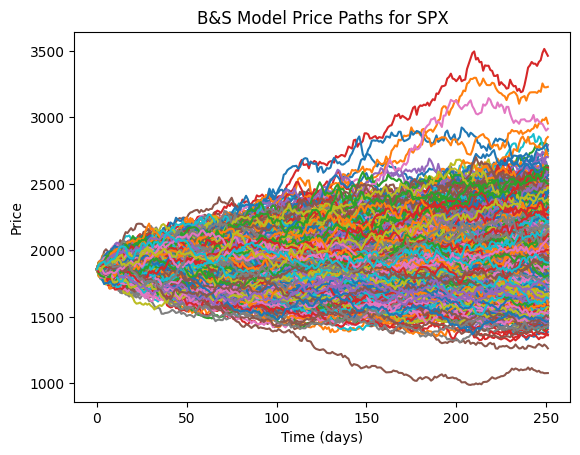

<Figure size 1000x600 with 0 Axes>

In [86]:
BS = BS_Pricer(S0, r, q, bs_sigma, T, exercise, K)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)
print(SBlackScholes.shape)

#### Merton Jump Diffusion

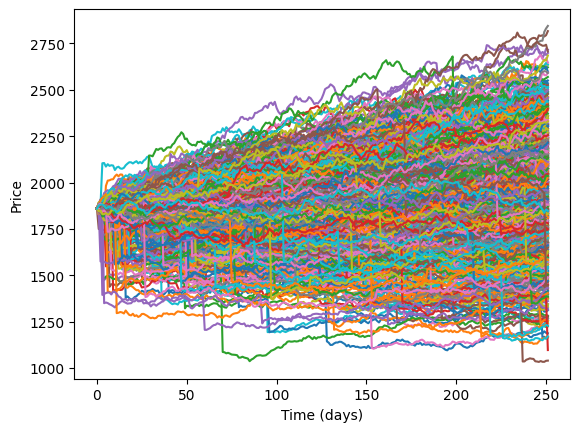

<Figure size 1000x600 with 0 Axes>

In [87]:
MERT = Merton_pricer(S0, K, T, r, q, mert_params[0], mert_params[1], mert_params[2], mert_params[3], exercise)
SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths

#### Kou Jump Diffusion

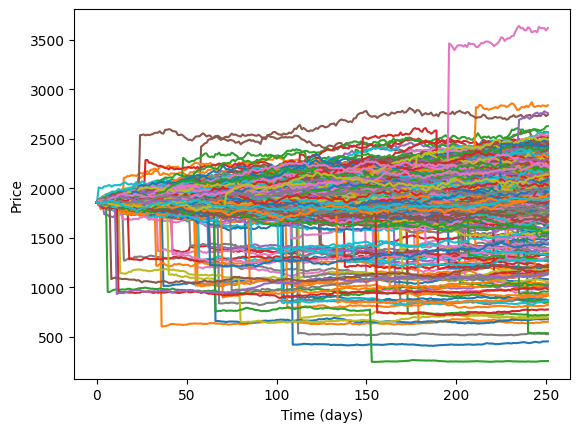

<Figure size 1000x600 with 0 Axes>

In [88]:
KOU = Kou_pricer(S0, K, ttm, r, kou_params[0], kou_params[1], kou_params[2], kou_params[3], kou_params[4], S0)
SKou = KOU.KouPath(days, paths)

# Plot all paths
KOU.plotKouPath(SKou, symbol)

#### Variance Gamma

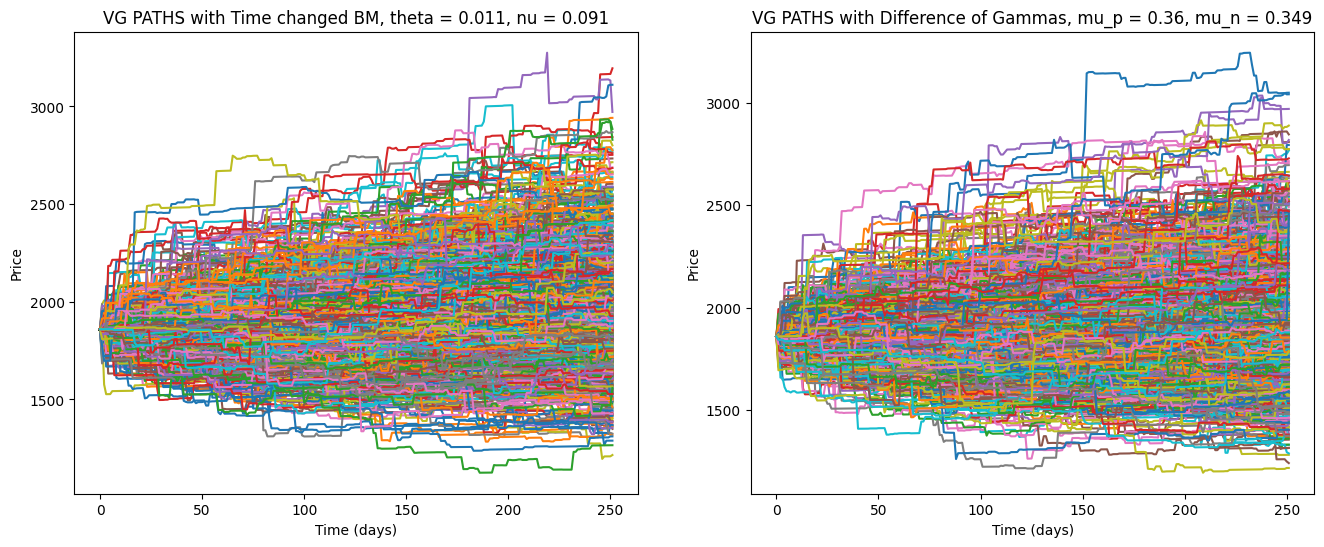

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [89]:
sigma, theta, nu = vg_params

VG = VG_pricer(S0, K, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()

In [90]:

mu_p = 0.5 * np.sqrt(
                theta ** 2 + (2 * sigma ** 2 / nu)) + 0.5 * theta  # positive jump mean
mu_n = 0.5 * np.sqrt(
                theta ** 2 + (2 * sigma ** 2 / nu)) - 0.5 * theta  # negative jump mean
nu_p = mu_p ** 2 * nu  # positive jump variamce
nu_n = mu_n ** 2 * nu  # negative jump variance

print('VG as Time changed brownian Motion. Parameters: ')
print(f'> Sigma = {sigma}\n> Theta = {theta}\n> Nu = {nu}')
print('VG as Time difference of gammas. Parameters: ')
print(f'> Mean Upward Jumps = {round(mu_p,3)}\n> Variance Upward Jumps = {round(nu_p,3)}')
print(f'> Mean Downward Jumps = {round(mu_n,3)}\n> Variance Downward Jumps = {round(nu_n,3)}')

VG as Time changed brownian Motion. Parameters: 
> Sigma = 0.151
> Theta = 0.0107
> Nu = 0.0909
VG as Time difference of gammas. Parameters: 
> Mean Upward Jumps = 0.36
> Variance Upward Jumps = 0.012
> Mean Downward Jumps = 0.349
> Variance Downward Jumps = 0.011


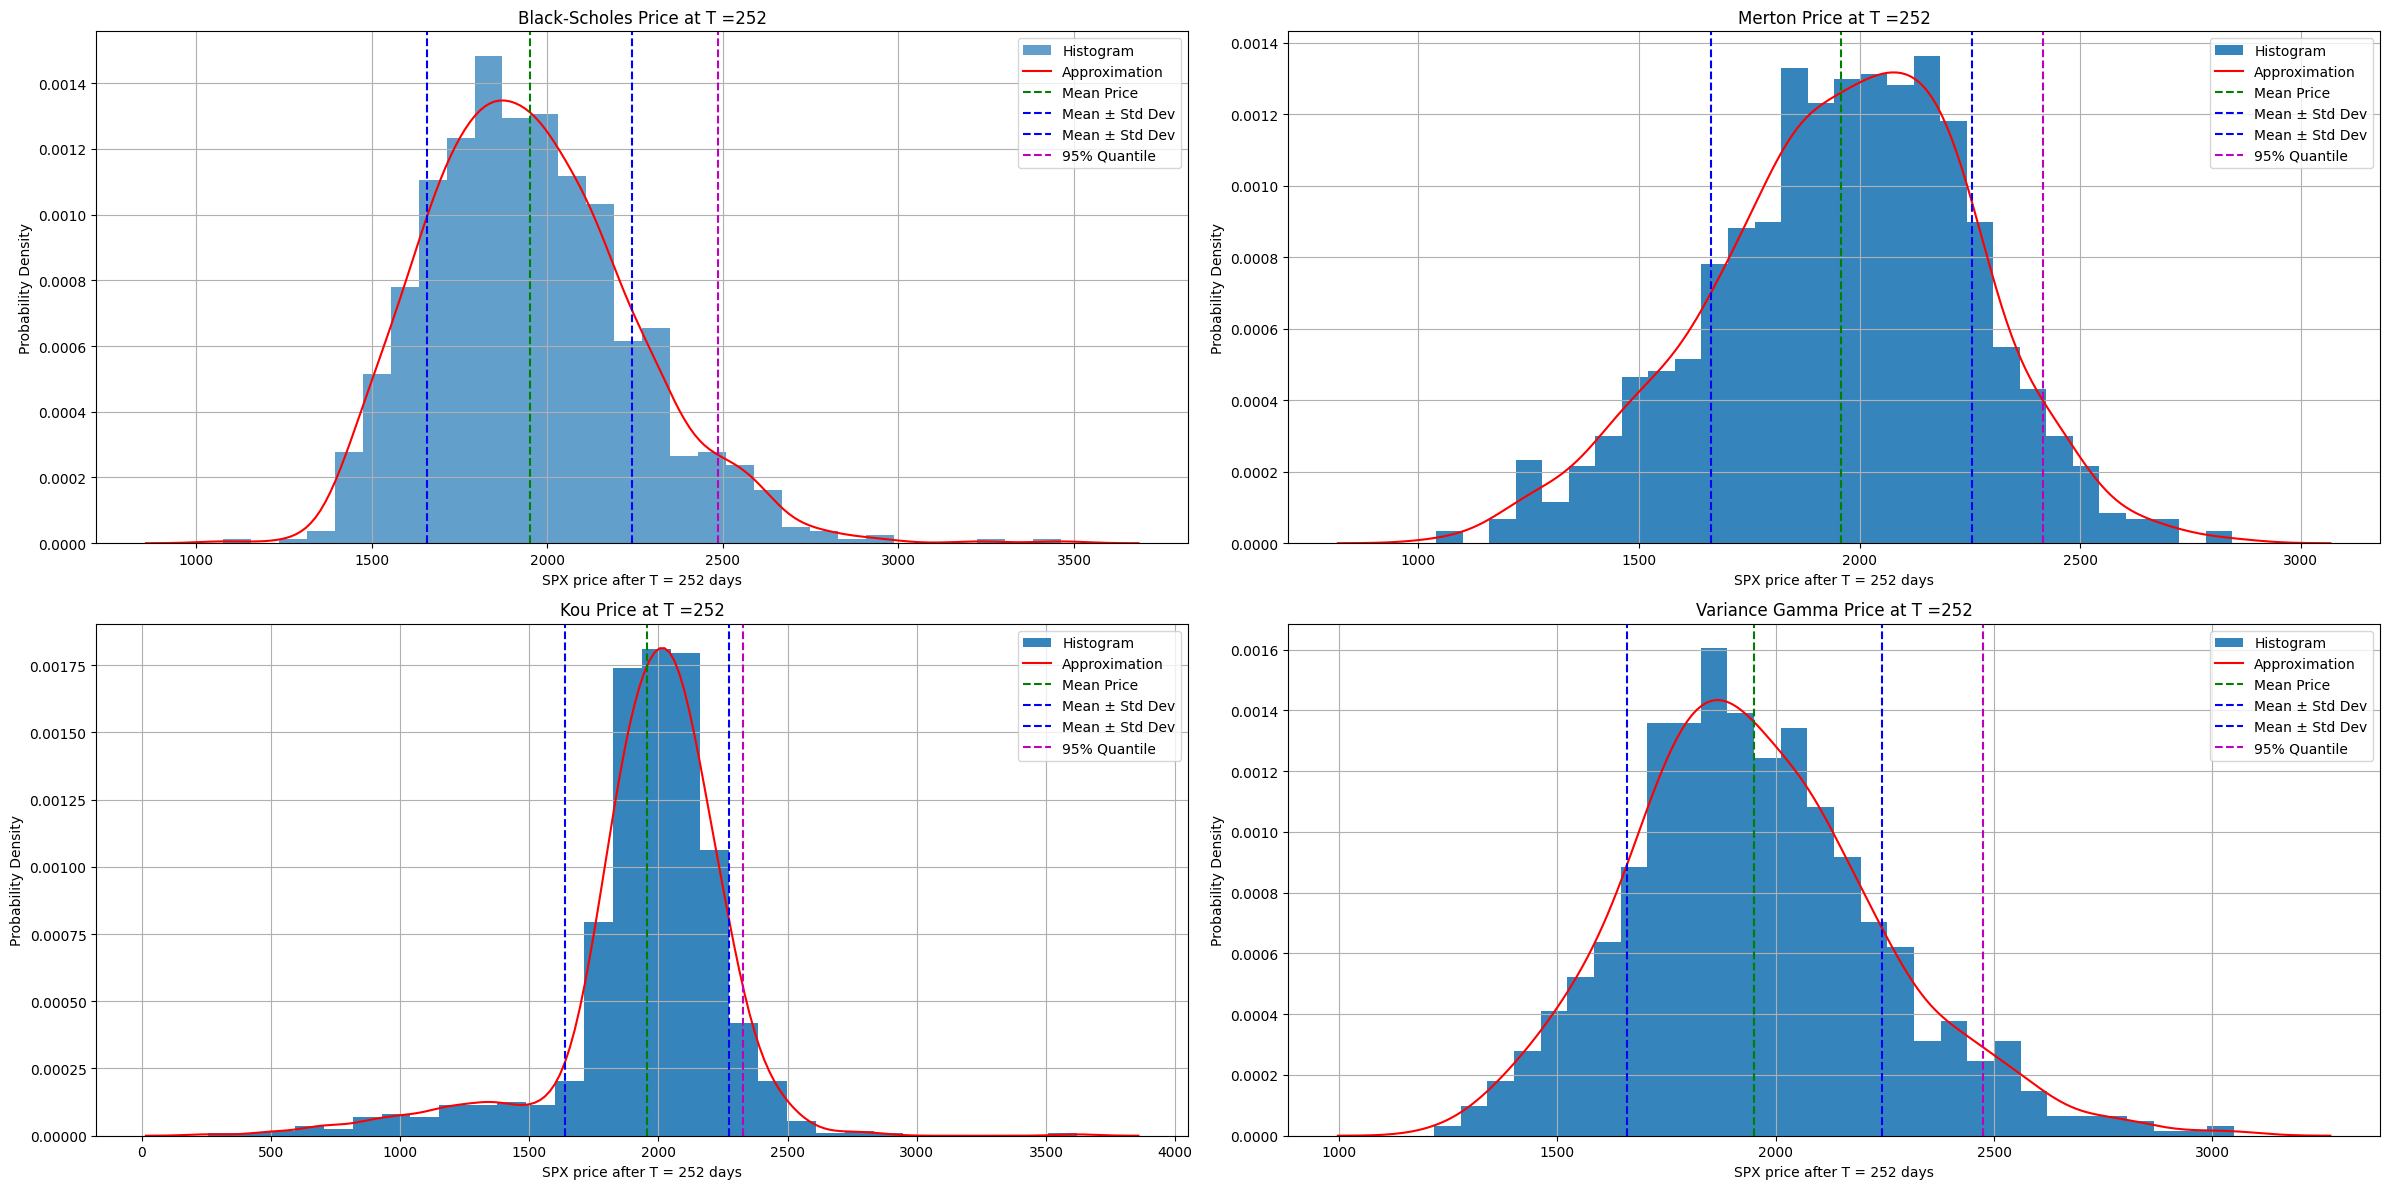

In [91]:
fig, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
BS.plotBSAtFixedTime(SBlackScholes, 251, symbol, ax = axes6[0,0])
MERT.plotMertonAtFixedTime(SMerton, 251, symbol, ax = axes6[0,1])
KOU.plotKouAtFixedTime(SKou, 251, symbol, ax = axes6[1,0])
VG.plotVGAtFixedTime(SVarGamma2, 251, symbol, ax = axes6[1,1])
plt.tight_layout()
plt.show()

Then we find the average value of the $N = 1000$ paths after $T=252$ days, i.e. one year later.

In [92]:
# Day-by-day mean of the 1000 paths, for each model
daily_avg = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarGamma1', 'VarGamma2'])
#daily_avg['Days'] = np.linspace(0,251,1)

daily_avg['BlackScholes'] = SBlackScholes.mean(axis=1)
daily_avg['Merton'] = SMerton.mean(axis=1)
daily_avg['Kou'] = SKou.mean(axis=1)
daily_avg['VarGamma1'] = SVarGamma.mean(axis=1)
daily_avg['VarGamma2'] = SVarGamma2.mean(axis=1)

In [93]:
print(daily_avg.tail())

     BlackScholes       Merton          Kou    VarGamma1    VarGamma2
247   1949.380188  1957.479170  1952.434074  1954.207935  1949.060455
248   1949.403825  1957.402420  1953.206843  1954.507855  1948.408970
249   1949.624425  1958.059945  1953.801353  1954.427032  1949.164476
250   1950.451080  1957.873405  1955.137451  1954.699225  1950.085905
251   1950.910958  1958.982147  1954.695985  1954.992559  1950.972997


In [94]:
# TODO: COSA è LA DERIVA VERSO IL BASSO? controlla formule'

St = S0 * np.exp(r * T)
print(St)

# Calculate the daily growth factor
daily_growth_factor = np.exp(r / days)

# Calculate the growth of prices day by day
St = S0 * np.cumprod(np.full(days, daily_growth_factor))

fig1 = go.Figure()
for column in daily_avg.columns:
    fig1.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=daily_avg[column], name=column))
fig1.add_trace(go.Scatter(x = spx_data.loc[0:251, 'Date'], y = St, name='Risk-free Growth'))

# Update the layout
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig1)

### MERTON DRIFT!!!
### CAPIRE KOU e VG come aggiustare drift

1954.659841426396


In [95]:
# Create a new figure
fig = go.Figure()

# Add trace for the real data
fig.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=spx_data.loc[0:251, 'Close'], name='Real Data'))

# Iterate over the simulated models and add traces for each model
for column in daily_avg.columns[:4]:
    fig.add_trace(go.Scatter(x=spx_data.loc[:, 'Date'], y=daily_avg[column], name=column))

# Update the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig)

### Monte Carlo simulation analysis

#### Volatility comparison of the Monte Carlo simulations

In [96]:
window_length = 1      #daily trading

# Log returns of all the Monte Carlo paths
log_returns_BS = np.log(SBlackScholes[1:] / SBlackScholes[:-1])
log_returns_MERT = np.log(SMerton[1:] / SMerton[:-1])
log_returns_KOU = np.log(SKou[1:] / SKou[:-1])
log_returns_VG = np.log(SVarGamma[1:] / SVarGamma[:-1])

realized_volatilities = [np.std(log_returns_BS[-window_length:]) * np.sqrt(252), np.std(log_returns_MERT[-window_length:]) * np.sqrt(252), np.std(log_returns_KOU[-window_length:]) * np.sqrt(252), np.std(log_returns_VG[-window_length:]) * np.sqrt(252)]


print("Realized volatilities per model:", realized_volatilities)


Realized volatilities per model: [0.1503349444902918, 0.15497663596292338, 0.246180504443191, 0.15462298500967223]


In [97]:
data = {
    'Historical': [sp_vola_1y]*4,
    'Implied': [bs_sigma, mert_params[0], kou_params[0], vg_params[0]],
    'Realized (MC paths)': realized_volatilities
}

volas = pd.DataFrame(data, index=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])

print('VOLATILITY COMPARISON: \n', volas)

#vg
# realized modelli di salto: depurare dai salti e calcolare quello che resta
# verificare realized vola

VOLATILITY COMPARISON: 
                Historical  Implied  Realized (MC paths)
BlackScholes     0.120312   0.1491             0.150335
Merton           0.120312   0.0878             0.154977
Kou              0.120312   0.0932             0.246181
VarianceGamma    0.120312   0.1510             0.154623


#### Jump Analysis of the Monte Carlo simulations

In [98]:
# How many Jumps in SPX data, according to estimate parameters

# MERTON MODEL
print(f'MERTON MODEL:\n>Average Jump intensity = {mert_params[2]}')
print(f'> Standard Deviation = {mert_params[3]}')
print(f'> Rate of jumps (num per year) λ = {mert_params[1]}')

jump = (mert_params[2] + mert_params[3])
jump_return = 1 - abs(jump)
print(jump_return)

MERTON MODEL:
>Average Jump intensity = -0.118
> Standard Deviation = 0.0963
> Rate of jumps (num per year) λ = 0.9085
0.9783


In [99]:
spx_jumps_real = spx_data[spx_data['Returns'] < jump_return].copy()
print(spx_jumps_real)

          Date         Open         High          Low        Close   
109 2016-06-24  2103.810059  2103.810059  2032.569946  2037.410034  \
162 2016-09-09  2169.080078  2169.080078  2127.810059  2127.810059   

         Volume   Returns  Log Returns  
109  7597450000  0.964080    -0.036581  
162  4233960000  0.975478    -0.024828  


In [100]:
highlight_dates = spx_jumps_real['Date'].tolist()

start_date = datetime(2016, 1, 20)
end_date = datetime(2017, 1, 20)

# Create the figure
fig = go.Figure()

# Add STOCK data to the figure
fig.add_trace(go.Scatter(x=spx_data['Date'].values, y=spx_data['Close'], name=symbol))

# Set the layout with the secondary y-axis
fig.update_layout(
    title=f'Highlight SPX jumps according to Merton model',
    xaxis_title='Date',
    yaxis=dict(
        title='SPX value',
        anchor='free',
        side='left',
        position=0.05
    ),
)


# Highlight the specific days
for date in highlight_dates:
    close_value = spx_data.loc[spx_data['Date'] == date, 'Close'].values[0]
    jump_size = spx_jumps_real.loc[spx_jumps_real['Date'] == date, 'Returns'].values[0]
    fig.add_annotation(
        x=date, y=close_value,
        text=f'Jump Size: {round(jump_size,4)}',
        showarrow=True,
        arrowhead=1,
        arrowsize=1.5,
        arrowwidth=2,
        arrowcolor='red',
        ax=20,
        ay=-40,
        xanchor='center',
        font=dict(color='red')
    )

# Display the figure
fig.show()

In [ ]:
# TODO: ANALISI DA FARE ANCHE PER GLI ALTRI MODELLI
